<a href="https://colab.research.google.com/github/dmitryglhf/jupyter-projects/blob/main/with_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libs

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.datasets import make_circles

import torch
import torch.nn as nn
import copy
import torch.optim as optim
import tqdm

### Functions

In [ ]:
def householder(a):
    v = a.copy()
    v[0] += np.sign(v[0]) * np.linalg.norm(a)
    v_dot = np.dot(v, v)

    if v_dot == 0:
        H = np.eye(len(a))
    else:
        H = np.eye(len(a)) - 2 * np.outer(v, v) / v_dot
    return H

def get_qr(A):
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()

    for j in range(n):
        a = R[j:, j]
        H = householder(a)
        R[j:, j:] = H @ R[j:, j:]
        Q[:, j:] = Q[:, j:] @ H.T

    return Q, R

def eig(A, e=1e-10, max_iter=1000):
    Ak = A.copy()
    eig_vectors = np.eye(A.shape[0])

    for i in range(max_iter):
        Q, R = get_qr(Ak)
        Ak = np.dot(R, Q)
        eig_vectors = np.dot(eig_vectors, Q)

        off_diag_norm = np.sqrt(np.sum(np.tril(Ak, -1) ** 2))
        if off_diag_norm < e:
            break

    eig_values = np.diag(Ak)
    return eig_values, eig_vectors

def svd(A):
    temp_U = A @ A.T
    eig_values_U, U = eig(temp_U)

    idx_U = np.argsort(eig_values_U)[::-1]
    eig_values_U = eig_values_U[idx_U]
    U = U[:, idx_U]

    sigma = np.zeros((A.shape[0], A.shape[1]))
    for i in range(min(A.shape[0], A.shape[1])):
        sigma[i, i] = np.sqrt(eig_values_U[i]) if eig_values_U[i] > 0 else 0

    sigma_inv = np.zeros_like(sigma.T)
    for i in range(min(A.shape[0], A.shape[1])):
        if sigma[i, i] > 0:
            sigma_inv[i, i] = 1 / sigma[i, i]

    V_T = sigma_inv @ U.T @ A
    S = np.diag(sigma)
    return U, S, V_T

def n_components(S):
    exp_var = S[0] / S.sum()
    k = 1
    while exp_var < 0.95:
        exp_var += S[k] / S.sum()
        k += 1
    return k, exp_var

def pca(X):
    U, S, V_T = svd(X)

    # Определение числа главных компонент
    k, exp_var = n_components(S)

    # Обрезаем матрицу до первых k компонент
    U_reduced = U[:, :k]
    sigma_reduced = np.diag(S[:k])

    # Возвращаем проекцию данных на первые k компонент
    X_reduced = U_reduced @ sigma_reduced

    return X_reduced, k, exp_var

### Data

In [ ]:
data = pd.read_csv('/content/Cancer_Data.csv')

# Преобразование категориальной переменной в бинарную
encoder = LabelEncoder()
data["diagnosis"] = encoder.fit_transform(data["diagnosis"])

# Удаление ненужных столбцов
columns_to_drop = ['id', 'Unnamed: 32']
data.drop(columns_to_drop, axis=1, inplace=True)

# 100
data = data.head(100)
X = data.drop('diagnosis', axis=1)
y = data["diagnosis"]

# Стандартизация данных (рекомендуется перед PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### PCA

In [ ]:
# Применение PCA
X_pca, k, exp_var = pca(X_scaled)

pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-7.698317,0.532763,1.249266,-4.133955,0.582280,0.336022,1.073617,0.566447,1.520837,1.169802,0.322455,0.011012,-0.647530,-0.847642,-0.713078,0.293024,0.212631,-0.054658,-0.181162,-0.154020
1,-1.025756,-4.381798,-0.113901,-1.325354,-0.836517,-0.397181,0.761768,-0.315427,-0.717176,0.259801,-0.673218,0.799430,0.585450,-0.062937,0.753668,-0.255414,0.071656,0.145538,0.139257,0.064420
2,-4.319619,-1.944501,0.176846,-1.002918,-0.250656,-0.041882,-0.269054,0.206476,-0.558500,-0.741435,0.186252,-0.249968,0.392534,0.394601,0.239482,0.518742,0.188144,-0.038077,0.244619,0.359709
3,-5.384167,8.837381,-1.010850,-0.804257,1.311130,1.778690,0.244014,-0.957489,-0.452674,0.696714,1.363856,0.032927,1.066428,-0.114981,0.669573,0.373267,0.173543,-0.201194,-0.010215,0.231115
4,-2.493849,-2.710930,2.383542,-2.558932,-0.333734,-2.128060,-1.010054,0.062399,-0.646078,0.151305,-0.267738,0.107604,-0.432225,-0.214917,0.739378,0.078386,-0.304813,-0.094245,-0.064803,-0.323726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-3.063363,-3.050409,0.657323,0.803240,-0.367183,0.969333,0.174126,-1.066526,-0.321059,0.341979,-0.815038,0.087351,-0.444846,0.206917,0.186903,0.138435,-0.004865,-0.322867,0.152219,0.137081
96,3.876201,0.005126,1.440454,0.088238,0.419205,0.664034,0.631704,1.249879,-0.128085,-0.376356,-0.063584,-0.297937,0.389942,0.008724,0.428363,-0.286223,0.330497,0.216788,-0.202625,0.067788
97,5.268532,1.001590,1.289408,1.646462,1.892163,-1.574276,0.259727,-0.363962,0.210541,1.037690,0.135278,-0.016705,-0.106058,-0.235547,0.232743,0.270653,0.406061,-0.034578,-0.237364,-0.153783
98,4.320335,0.434070,-0.472230,-1.959653,-0.690247,-0.438932,0.518925,0.285875,0.083751,0.544774,0.415527,-0.027166,0.058717,-0.501785,-0.033663,-0.010539,-0.375240,0.121519,0.186200,0.149401


### Build network

In [ ]:
class MyNN(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.hidden = nn.Linear(n, n)
        self.relu = nn.ReLU()
        self.output = nn.Linear(n, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
X_pca.shape[1]

20

In [ ]:
model = MyNN(X_pca.shape[1])
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

441


In [ ]:
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

### PCA test

In [ ]:
X = torch.tensor(X_pca, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [ ]:
%%time
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

In [ ]:
with torch.no_grad():
    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

### Kernel PCA

In [ ]:
# Определение радиально-базисного ядра (RBF)
def rbf(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

# Полиномиальное ядро
def polynomial(x1, x2, degree, coef0):
    return (np.dot(x1, x2) + coef0) ** degree

# Сигмоидное ядро
def sigmoid(x1, x2, gamma, coef0):
    return np.tanh(gamma * np.dot(x1, x2) + coef0)

# Функция для вычисления Kernel Matrix
def compute_kernel_matrix(X, kernel_func, gamma=None, degree=None, coef0=None):
    rows = X.shape[0]
    K = np.zeros((rows, rows))

    for i in range(rows):
        for j in range(i, rows):
            if kernel_func == rbf:
                K[i, j] = kernel_func(X[i], X[j], gamma)
            elif kernel_func == polynomial:
                K[i, j] = kernel_func(X[i], X[j], degree, coef0)
            elif kernel_func == sigmoid:
                K[i, j] = kernel_func(X[i], X[j], gamma, coef0)
            K[j, i] = K[i, j]  # Используем симметричность

    return K

# Центрирование матрицы ядра
def center_kernel(K):
    N = K.shape[0]
    one_N = np.ones((N, N)) / N
    return K - one_N @ K - K @ one_N + one_N @ K @ one_N

# Функция Kernel PCA
def kernel_pca(X, n_components, kernel='rbf', gamma=None, degree=3, coef0=1):
    rows, cols = X.shape

    # Устанавливаем значения по умолчанию для gamma
    if gamma is None:
        gamma = 1.0 / cols

    # Словарь для выбора функции ядра
    if kernel == 'rbf':
        kernel_func = rbf
    elif kernel == 'poly':
        kernel_func = polynomial
    elif kernel == 'sigmoid':
        kernel_func = sigmoid
    else:
        return

    # Вычисляем Kernel Matrix
    if kernel == 'rbf' or kernel == 'sigmoid':
        K = compute_kernel_matrix(X, kernel_func, gamma=gamma, coef0=coef0)
    elif kernel == 'poly':
        K = compute_kernel_matrix(X, kernel_func, degree=degree, coef0=coef0)

    # center kernel matrix
    K_centered = center_kernel(K)

    # Выполняем собственное разложение
    eigvals, eigvecs = eig(K_centered)

    # Сортируем по убыванию собственных значений
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Выбираем первые n_components собственных векторов и значений
    v = eigvecs[:, :n_components]
    vals = eigvals[:n_components]

    # Нормализация собственных векторов
    v /= (np.sqrt(vals)*np.linalg.norm(v))  # делить на норму вектора умноженную на корень из собств знач (для каждого вектора своё)

    # Возвращаем проекцию данных на пространство главных компонент
    return np.dot(K_centered, v)

In [ ]:
# 1. запустить код и проверить что получается матрица
# 2. scatter
# 3. присобачить ноутбук вадика
# 4. сравнить скаттер наш и скаттер у вадика
# 5. слепить в один ноутбук

### Circles dataset

In [ ]:
X_c, y_c = make_circles(n_samples=100, factor=0.3, noise=0.03, random_state=0)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, stratify=y_c, random_state=0)

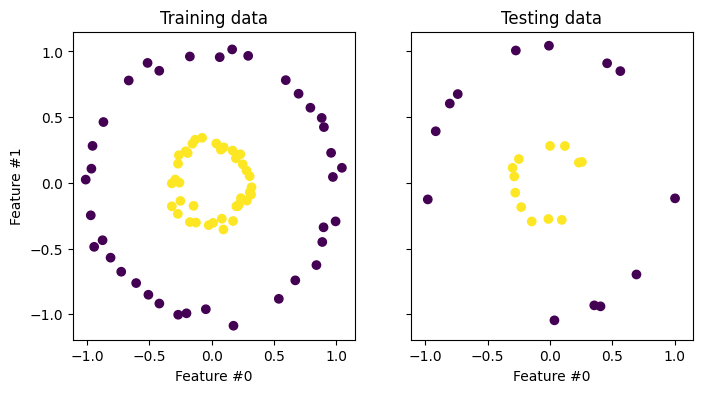

In [ ]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train_c[:, 0], X_train_c[:, 1], c=y_train_c)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test_c[:, 0], X_test_c[:, 1], c=y_test_c)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

### Kernel PCA test

In [ ]:
X_kernel_pca = kernel_pca(X_c, 2)

In [ ]:
pd.DataFrame(X_kernel_pca)

,0,1
0,0.095314,-0.441645
1,0.179154,0.006673
2,-0.143827,0.432354
3,-0.115166,0.141997
4,0.019156,-0.207973
...,...,...
95,0.061557,0.159415
96,-0.137605,-0.139117
97,-0.184493,-0.015907
98,0.121167,0.435420


ValueError: 'c' argument has 25 elements, which is inconsistent with 'x' and 'y' with size 100.

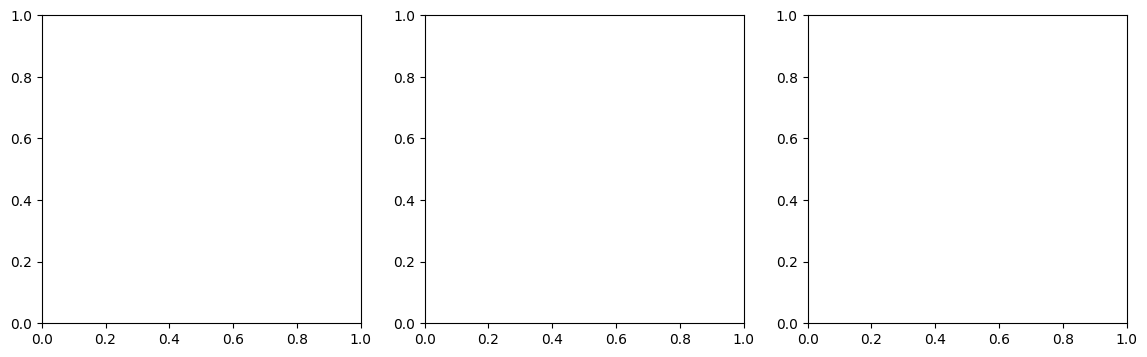

In [ ]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

kernel_pca_proj_ax.scatter(X_kernel_pca[:, 0], X_kernel_pca[:, 1], c =y_test_c)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")